In [ ]:
# Install required packages
!pip install --upgrade --quiet natural-pdf[ai,ocr-export]

print('✓ Packages installed!')

**Slides:** [slides.pdf](./slides.pdf)

# Let's ask questions

Time for some AI magic. We're using **extractive question answering**, which is different from LLMs because it pulls content *from the page*. LLMs are *generative AI*, which take your question and generates *new* text.

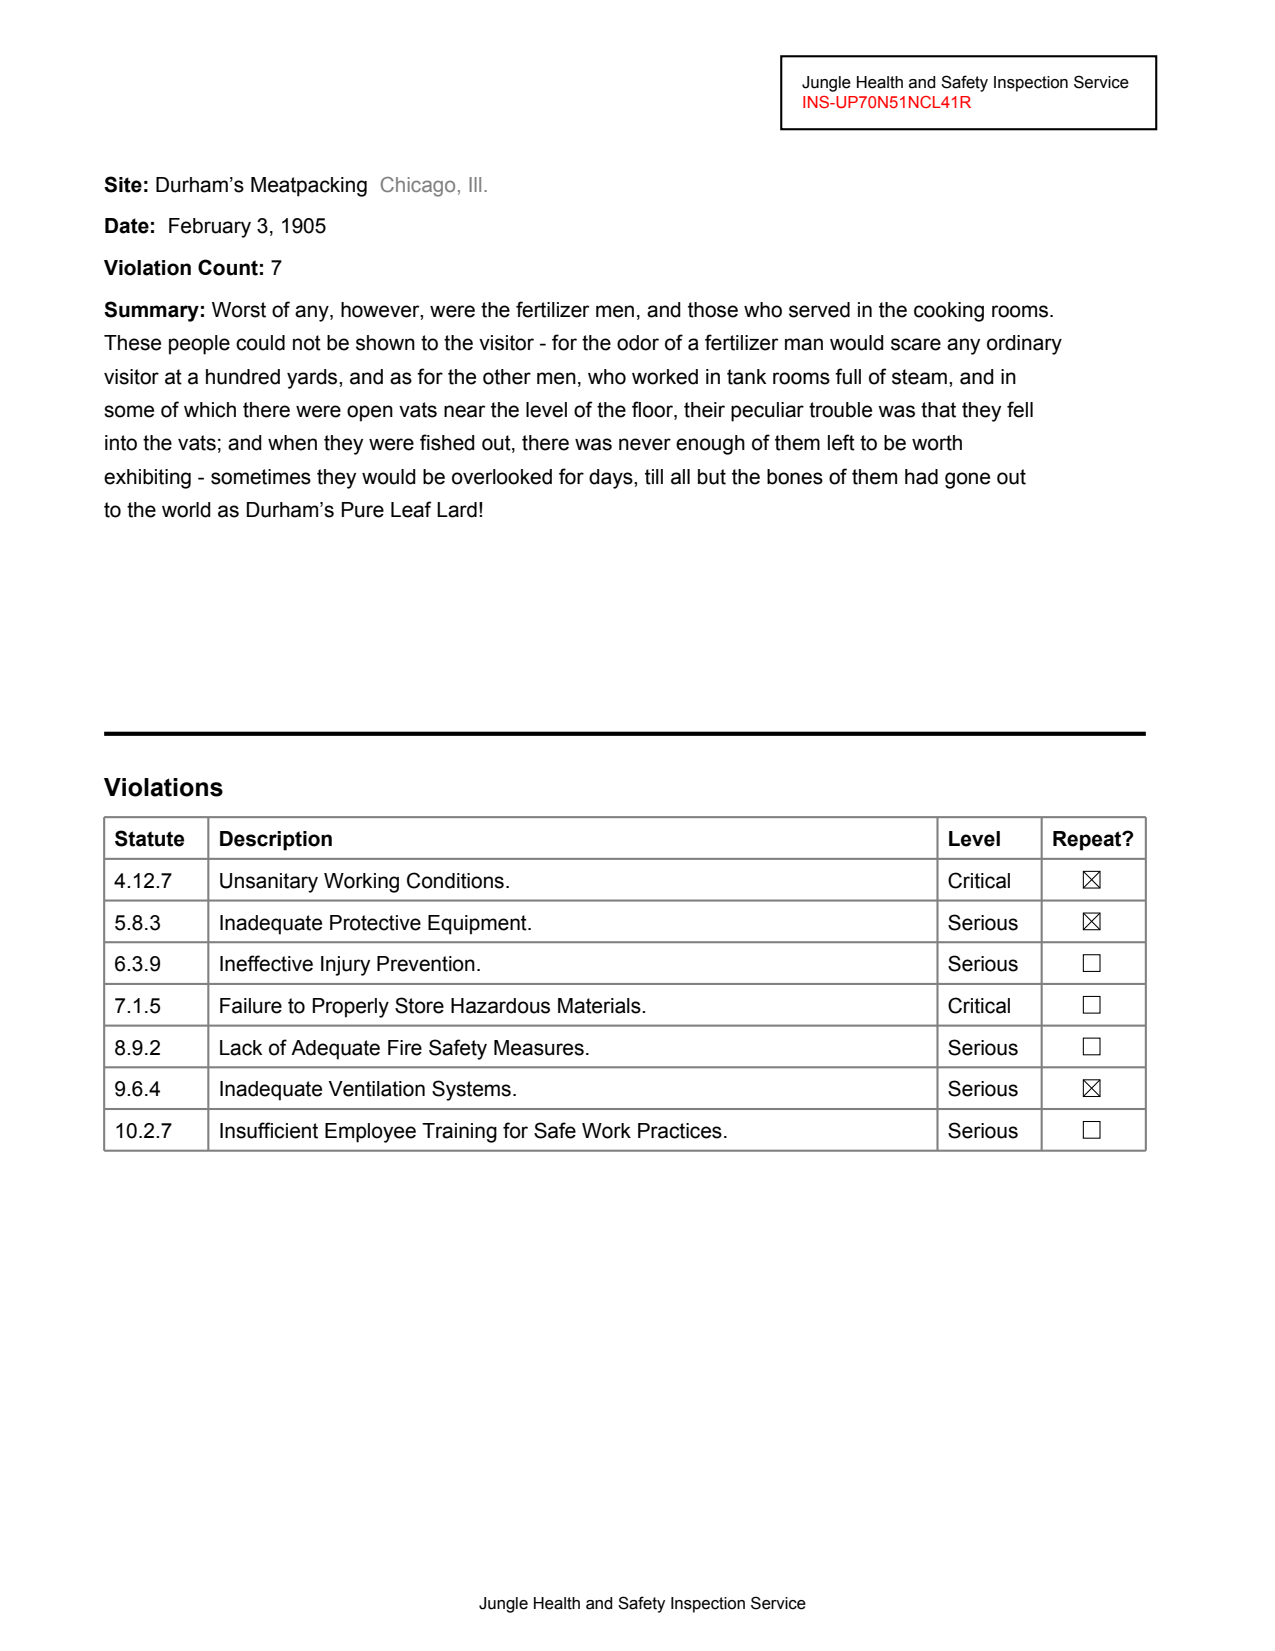

In [3]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/practice.pdf")
page = pdf.pages[0]
page.show()

In [4]:
result = page.ask("What date was the inspection?")
result

Device set to use mps


{'question': 'What date was the inspection?',
 'answer': 'February 3, 1905',
 'confidence': 0.9851913452148438,
 'start': 6,
 'end': 6,
 'found': True,
 'page_num': 0,
 'source_elements': <ElementCollection[TextElement](count=1)>}

Notice it has a **confidence score**, which makes life great. You can also use `.show()` to see where it's getting the answer from.

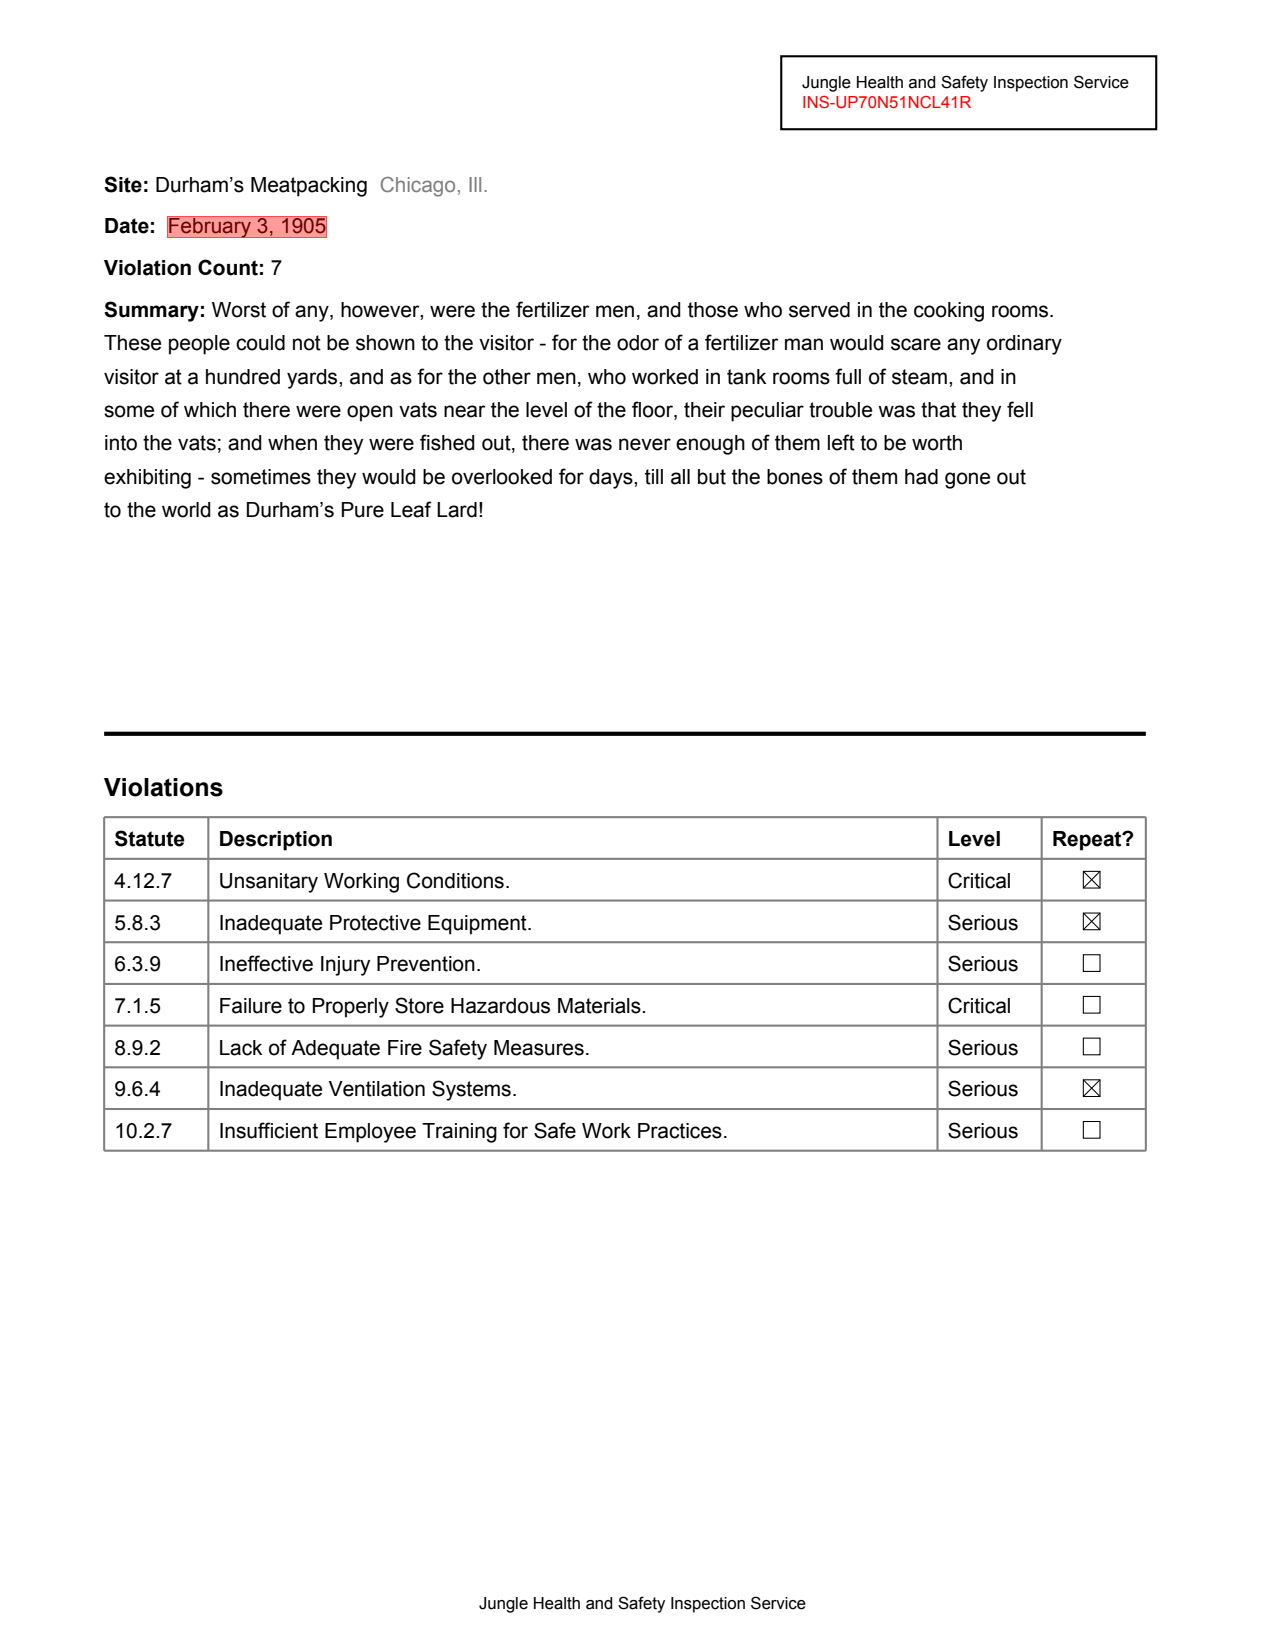

In [5]:
result.show()

It automatically doesn't show you answers it doesn't have much faith in. Let's ask for the **Summary**.

In [8]:
page.ask("Summary")

{'question': 'Summary',
 'answer': '',
 'confidence': 0.04887579753994942,
 'start': 9,
 'end': 10,
 'found': False,
 'page_num': 0}

In [9]:
page.ask("Summary", min_confidence=0.0)

{'question': 'Summary',
 'answer': 'Summary:  Worst of any, however, were the fertilizer men, and those who served in the cooking rooms.',
 'confidence': 0.04887579753994942,
 'start': 9,
 'end': 10,
 'found': True,
 'page_num': 0,
 'source_elements': <ElementCollection[TextElement](count=2)>}

That does NOT mean it's always accurate, though. Using the words on the page makes it a lot easier. **How should we ask about the number of violations?**

In [10]:
#result = page.ask("How many violations were there?")
result = page.ask("What was the violation count?")
result

{'question': 'What was the violation count?',
 'answer': 'Violation Count:  7',
 'confidence': 0.9995834231376648,
 'start': 7,
 'end': 8,
 'found': True,
 'page_num': 0,
 'source_elements': <ElementCollection[TextElement](count=2)>}

We can also ask for **muliple things at once.**

In [11]:
answers = page.ask(['violation count', 'site', 'location'])
answers

[{'question': 'violation count',
  'answer': '7',
  'confidence': 0.40883421897888184,
  'start': 8,
  'end': 8,
  'found': True,
  'page_num': 0,
  'source_elements': <ElementCollection[TextElement](count=1)>},
 {'question': 'site',
  'answer': 'Durham’s Meatpacking  ',
  'confidence': 0.579147458076477,
  'start': 3,
  'end': 3,
  'found': True,
  'page_num': 0,
  'source_elements': <ElementCollection[TextElement](count=1)>},
 {'question': 'location',
  'answer': 'Chicago, Ill.',
  'confidence': 0.9557958245277405,
  'start': 4,
  'end': 4,
  'found': True,
  'page_num': 0,
  'source_elements': <ElementCollection[TextElement](count=1)>}]

There are better ways to extract structured data, though.

## Structured data generation

### Using extractive Doc Q&A (same as `.ask`)

In [13]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
page = pdf.pages[0]

You can use `page.extract` to (attempt to) extract structured data.

In [14]:
page.extract(["site", "date", "violation count", "inspection service", "summary", "city", "state"])

<Page number=1 index=0>

In [15]:
page.extracted()
dict(page.extracted())

{'site': 'Durham’s Meatpacking  ',
 'date': 'February 3, 1905',
 'violation_count': '7',
 'inspection_service': 'Jungle Health and Safety Inspection Service',
 'summary': None,
 'city': 'Chicago, Ill.',
 'state': 'Chicago, Ill.',
 'site_confidence': 0.579147458076477,
 'date_confidence': 0.999687135219574,
 'violation_count_confidence': 0.40883421897888184,
 'inspection_service_confidence': 0.8848592638969421,
 'summary_confidence': 0.025302845984697342,
 'city_confidence': 0.7950754761695862,
 'state_confidence': 0.9988866448402405}

In [16]:
page.extracted('city')

'Chicago, Ill.'

## Leveraging an LLM for structured data

Sometimes you want an opinion from an LLM, though. You want it to write things that aren't in there, or piece together something complicated. It's worth the potential for hallucinations!

Below we're using Google thanks to its [OpenAI compatibility](https://ai.google.dev/gemini-api/docs/openai).

In [18]:
import os
from openai import OpenAI

# Initialize your LLM client
# Anything OpenAI-compatible works!
client = OpenAI(
    api_key=os.environ["GOOGLE_API_KEY"],  # Your API key
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"  # Changes based on what AI you're using
)

fields = ["site", "date", "violation count", "inspection service", "summary", "city", "state"]
page.extract(fields, client=client, model="gemini-2.0-flash-lite") 

<Page number=1 index=0>

In [19]:
dict(page.extracted())

{'site': 'Durham’s Meatpacking',
 'date': 'February 3, 1905',
 'violation_count': '7',
 'inspection_service': 'Jungle Health and Safety Inspection Service',
 'summary': 'Worst of any, however, were the fertilizer men, and those who served in the cooking rooms. These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in some of which there were open vats near the level of the floor, their peculiar trouble was that they fell into the vats; and when they were fished out, there was never enough of them left to be worth exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out to the world as Durham’s Pure Leaf Lard!',
 'city': 'Chicago',
 'state': 'Ill.'}

### Very intense structured data extraction

Instead of being kind of loose and free with what you want, you can also get MUCH fancier and write a Pydantic model. It will not only send the column names you want, but also little descriptions and demands about strings (text), integers, floats and more.

You can find more details [here](https://platform.openai.com/docs/guides/structured-outputs).

In [30]:
from pydantic import BaseModel, Field
from openai import OpenAI

# Initialize your LLM client
# Anything OpenAI-compatible works!
client = OpenAI(
    api_key=os.environ["GOOGLE_API_KEY"],
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

# Define your schema
class ReportInfo(BaseModel):
    inspection_number: str = Field(description="The main report identifier")
    inspection_date: str = Field(description="The name of the issuing company")
    inspection_service: str = Field(description="Name of inspection service")
    site: str = Field(description="Name of company inspected")
    summary: str = Field(description="Visit summary")
    city: str
    state: str = Field(description="Full name of state")
    violation_count: int

# Extract data
# page.extract(schema=ReportInfo, client=client, model="gemini-2.5-flash-lite") 
page.extract(schema=ReportInfo, client=client, model="gemini-2.5-flash") 

<Page number=1 index=0>

In [31]:
page.extracted() 

ReportInfo(inspection_number='INS-UP70N51NCL41R', inspection_date='February 3, 1905', inspection_service='Jungle Health and Safety Inspection Service', site='Durham’s Meatpacking', summary='Worst of any, however, were the fertilizer men, and those who served in the cooking rooms. These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in some of which there were open vats near the level of the floor, their peculiar trouble was that they fell into the vats; and when they were fished out, there was never enough of them left to be worth exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out to the world as Durham’s Pure Leaf Lard!', city='Chicago', state='Illinois', violation_count=7)

In [32]:
dict(page.extracted())

{'inspection_number': 'INS-UP70N51NCL41R',
 'inspection_date': 'February 3, 1905',
 'inspection_service': 'Jungle Health and Safety Inspection Service',
 'site': 'Durham’s Meatpacking',
 'summary': 'Worst of any, however, were the fertilizer men, and those who served in the cooking rooms. These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in some of which there were open vats near the level of the floor, their peculiar trouble was that they fell into the vats; and when they were fished out, there was never enough of them left to be worth exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out to the world as Durham’s Pure Leaf Lard!',
 'city': 'Chicago',
 'state': 'Illinois',
 'violation_count': 7}

In [26]:
page.extracted('inspection_date')

'February 3, 1905'

## Table extraction with LLMs

In the example below, we're saying "Using Gemini, provide a violations table - each row should have a statute, a description, a level, and a repeat-checked

In [39]:
from pydantic import BaseModel, Field
from openai import OpenAI
from typing import List, Literal

client = OpenAI(
    api_key=os.environ["GOOGLE_API_KEY"],
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

class ViolationsRow(BaseModel):
    statute: str
    description: str
    level: str
    repeat_checked: Literal["checked", "unchecked"] = Field("Whether the checkbox is checked or not")

class ViolationsTable(BaseModel):
    inspection_id: str
    violations: List[ViolationsRow]

page.extract(schema=ViolationsTable, client=client, model="gemini-2.5-flash") 

<Page number=1 index=0>

Note that when we look below... **it didn't do the checked/unchecked correctly!**

In [40]:
import pandas as pd

data = page.extracted()
pd.DataFrame(data.model_dump()['violations'])

,statute,description,level,repeat_checked
0,4.12.7,Unsanitary Working Conditions.,Critical,unchecked
1,5.8.3,Inadequate Protective Equipment.,Serious,unchecked
2,6.3.9,Ineffective Injury Prevention.,Serious,unchecked
3,7.1.5,Failure to Properly Store Hazardous Materials.,Critical,unchecked
4,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,unchecked
5,9.6.4,Inadequate Ventilation Systems.,Serious,unchecked
6,10.2.7,Insufficient Employee Training for Safe Work P...,Serious,unchecked


## Figuring out how to manage those pesky checkboxes

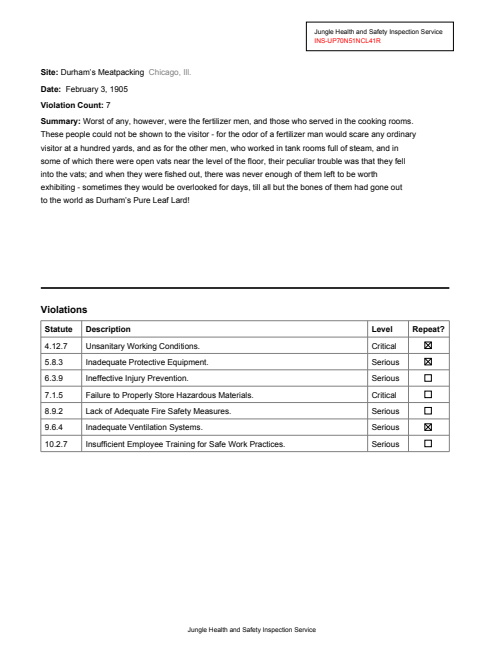

In [2]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
page = pdf.pages[0]
page.show(width=500)

We can use .extract_table() no problem to get *most* of the columns, but we really really want those checkboes!

In [3]:
import pandas as pd

df = page.extract_table().to_df()
df

,Statute,Description,Level,Repeat?
0,4.12.7,Unsanitary Working Conditions.,Critical,<NA>
1,5.8.3,Inadequate Protective Equipment.,Serious,<NA>
2,6.3.9,Ineffective Injury Prevention.,Serious,<NA>
3,7.1.5,Failure to Properly Store Hazardous Materials.,Critical,<NA>
4,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,<NA>
5,9.6.4,Inadequate Ventilation Systems.,Serious,<NA>
6,10.2.7,Insufficient Employee Training for Safe Work P...,Serious,<NA>


Let's find all of the boxes below the "Violations" header...

In [4]:
boxes = (
    page
    .find(text='Violations')
    .below()
    .find_all('rect')
)

boxes.show(crop=True)

Let's go through each box: **do you have a line inside of you?**

In [5]:
rect1 = boxes[1]
rect1.show(crop=True)

In [6]:
rect1.find('line')

<LineElement type=None width=0.5 bbox=(520.0, 438.0, 528.0, 446.0)>

In [7]:
rect2 = boxes[4]
rect2.show(crop=True)

In [8]:
rect2.find('line')

We can use `.apply` to go through each box and say 'yes' if there's a line, and 'no' otherwise.

In [9]:
(
    page
    .find(text='Violations')
    .below()
    .find_all('rect')
    .apply(lambda box: 'yes' if box.find('line') else 'no')
)

<ElementCollection[str](count=7)>

In [10]:
df['repeat'] = (
    page
    .find(text='Violations')
    .below()
    .find_all('rect')
    .apply(lambda box: 'yes' if box.find('line') else 'no')
)
df.head()

,Statute,Description,Level,Repeat?,repeat
0,4.12.7,Unsanitary Working Conditions.,Critical,<NA>,yes
1,5.8.3,Inadequate Protective Equipment.,Serious,<NA>,yes
2,6.3.9,Ineffective Injury Prevention.,Serious,<NA>,no
3,7.1.5,Failure to Properly Store Hazardous Materials.,Critical,<NA>,no
4,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,<NA>,no


## Classification

But what if it's an *image* of a rectangle that's checked or unchecked? No worries, AI to the rescue yet again! And this time it's a *local model*, something where you don't have to rely on ChatGPT or Anthropic or any of those.

In [11]:
rect1 = page.find_all('rect')[2].expand(-1)
rect1.show(crop=True)

We can use `.classify` and `.category` to see whether it's a square or an X. Or checked vs unchecked? ...or blank or an X?

In [12]:
# rect1.classify(['square', 'X']).category
#rect1.classify(['checked', 'unchecked'], using="vision").category
rect1.classify(['blank', 'X'], using="vision").category

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


'X'

In [65]:
rect2 = page.find_all('rect')[5].expand(-1)
rect2.show(crop=True)

In [67]:
rect2.classify(['blank', 'X'], using="vision").category

'blank'

In [69]:
boxes = (
    page
    .find(text='Violations')
    .below()
    .find_all('rect')
    .expand(-1)
)
boxes.show(crop=True)

In [70]:
(
    boxes
    .classify_all(['blank', 'X'], using="vision")
    .apply(lambda r: r.category)
)

Classifying batch (openai/clip-vit-base-patch16):   0%|          | 0/7 [00:00<?, ?it/s]

<ElementCollection[str](count=7)>

In [71]:
df['repeat'] = (
    boxes
    .classify_all(['blank', 'X'], using="vision")
    .apply(lambda r: r.category)
)
df

Classifying batch (openai/clip-vit-base-patch16):   0%|          | 0/7 [00:00<?, ?it/s]

,Statute,Description,Level,Repeat?,repeat
0,4.12.7,Unsanitary Working Conditions.,Critical,<NA>,X
1,5.8.3,Inadequate Protective Equipment.,Serious,<NA>,X
2,6.3.9,Ineffective Injury Prevention.,Serious,<NA>,blank
3,7.1.5,Failure to Properly Store Hazardous Materials.,Critical,<NA>,blank
4,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,<NA>,blank
5,9.6.4,Inadequate Ventilation Systems.,Serious,<NA>,X
6,10.2.7,Insufficient Employee Training for Safe Work P...,Serious,<NA>,blank


# Putting things in categories

## Categorizing an entire PDF

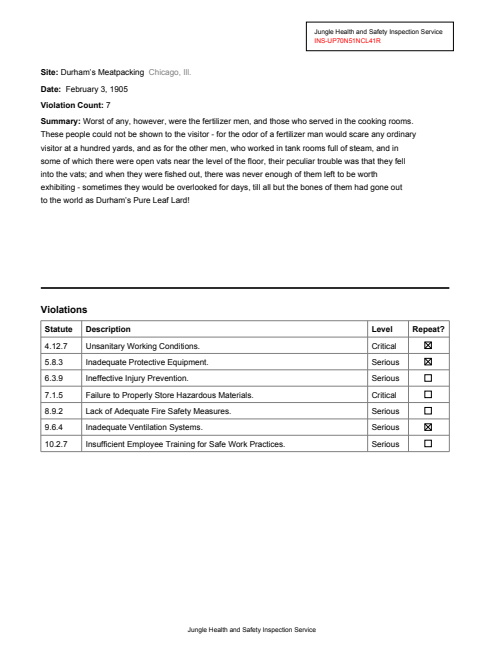

In [72]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
page = pdf.pages[0]
page.show(width=500)

What can we classify the entire PDF as? Maybe a... slaughterhouse report? A dolphin training manual? Something about basketball or birding?

In [73]:
pdf.classify(['slaughterhouse report', 'dolphin training manual', 'basketball', 'birding'], using='text')
pdf.category

Device set to use mps:0


'slaughterhouse report'

In [74]:
pdf.category_confidence

0.8695732951164246

## Classifying pages of a PDF

Let's take a look at a document from the CIA investigating whether you can **use pigeons as spies**.

In [ ]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/ire25-natural-pdf/raw/refs/heads/main/cia-doc.pdf")
pdf.pages.to_image(cols=6)

Just like we did above, we can ask what category we think the PDF belongs to.

In [ ]:
pdf.classify(['slaughterhouse report', 'dolphin training manual', 'basketball', 'birding'], using='text')
(pdf.category, pdf.category_confidence)

But notice how all of the pages look very very different: **we can also categorize each page using vision**.

In [ ]:
pdf.classify_pages(['diagram', 'text', 'invoice', 'blank'], using='vision')

for page in pdf.pages:
    print(f"Page {page.number} is {page.category} - {page.category_confidence:0.3}")

And if we just want to see the pages that are diagrams, we can `.filter` for them.

In [ ]:
(
    pdf.pages
    .filter(lambda page: page.category == 'diagram')
    .to_image(show_category=True)
)


And if that's all we're interested in? We can save a new PDF of just those pages!

In [ ]:
(
    pdf.pages
    .filter(lambda page: page.category == 'diagram')
    .save_pdf("diagrams.pdf", original=True)
)